### Import required packages and dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhads\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhads\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dhads\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
data = pd.read_excel("P597 DATASET.xlsx")
data.head()

,title,rating,body
0,Horrible product,1,Very disappointed with the overall performance...
1,Camera quality is not like 48 megapixel,3,Camera quality is low
2,Overall,4,"Got the mobile on the launch date,Battery must..."
3,A big no from me,1,1. It doesn't work with 5.0GHz WiFi frequency....
4,Put your money somewhere else,1,"Not worth buying....faulty software, poor disp..."


### Exploration

In [6]:
print("Data Information:")
display(data.info())

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1440 non-null   object
 1   rating  1440 non-null   int64 
 2   body    1440 non-null   object
dtypes: int64(1), object(2)
memory usage: 33.9+ KB


None

In [7]:
if(data.duplicated().sum() > 0):
    print("There are duplicate rows in the dataset.")
    display(data[data.duplicated()])
else:
    print("No duplicate rows found in the dataset.")

No duplicate rows found in the dataset.


In [8]:
print("\nMissing Values in Each Column:")
display(data.isnull().sum())


Missing Values in Each Column:


title     0
rating    0
body      0
dtype: int64

In [9]:
print("\nStatistical Summary of Numerical Columns:")
display(data.describe())


Statistical Summary of Numerical Columns:


,rating
count,1440.000000
mean,3.173611
std,1.584453
min,1.000000
25%,1.000000
50%,4.000000
75%,5.000000
max,5.000000


### Rating distribution

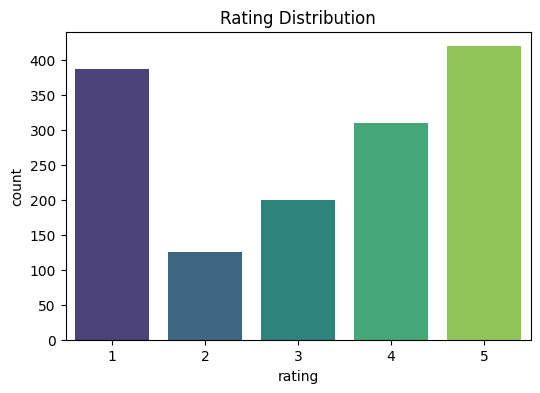

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=data, palette='viridis')
plt.title("Rating Distribution")
plt.show()

### Combine title and body into one text column

In [11]:
data['text'] = data['title'].astype(str) + " " + data['body'].astype(str)
data.drop(['title', 'body'], axis=1, inplace=True)
data.head()

,rating,text
0,1,Horrible product Very disappointed with the ov...
1,3,Camera quality is not like 48 megapixel Camera...
2,4,"Overall Got the mobile on the launch date,Batt..."
3,1,A big no from me 1. It doesn't work with 5.0GH...
4,1,Put your money somewhere else Not worth buying...


### Language detect

In [12]:
from langdetect import detect

data['language'] = data['text'].apply(lambda x: detect(x))
print(data['language'].value_counts())

language
en    1412
hi      11
id       6
af       3
ca       2
lv       1
ml       1
de       1
so       1
no       1
fr       1
Name: count, dtype: int64


### Translate unknown language

In [13]:
from deep_translator import GoogleTranslator

# Function to translate only if not English
def translate_text(text, lang):
    try:
        if lang != 'en':  # translate only non-English reviews
            return GoogleTranslator(source='auto', target='en').translate(text)
        else:
            return text
    except:
        return text  # if translation fails, keep original

# Apply translation only where needed
data['text'] = data.apply(lambda x: translate_text(x['text'], x['language']), axis=1)

### Text cleaning function (normalization + punctuation removal)

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    return text

data['clean_text'] = data['text'].apply(clean_text)
data.head()

,rating,text,language,clean_text
0,1,Horrible product Very disappointed with the ov...,en,horrible product very disappointed with the ov...
1,3,Camera quality is not like 48 megapixel Camera...,en,camera quality is not like megapixel camera qu...
2,4,"Overall Got the mobile on the launch date,Batt...",en,overall got the mobile on the launch datebatte...
3,1,A big no from me 1. It doesn't work with 5.0GH...,en,a big no from me it doesnt work with ghz wifi ...
4,1,Put your money somewhere else Not worth buying...,en,put your money somewhere else not worth buying...


### Tokenization

In [15]:
data['tokens'] = data['clean_text'].apply(word_tokenize)
data.head()

,rating,text,language,clean_text,tokens
0,1,Horrible product Very disappointed with the ov...,en,horrible product very disappointed with the ov...,"[horrible, product, very, disappointed, with, ..."
1,3,Camera quality is not like 48 megapixel Camera...,en,camera quality is not like megapixel camera qu...,"[camera, quality, is, not, like, megapixel, ca..."
2,4,"Overall Got the mobile on the launch date,Batt...",en,overall got the mobile on the launch datebatte...,"[overall, got, the, mobile, on, the, launch, d..."
3,1,A big no from me 1. It doesn't work with 5.0GH...,en,a big no from me it doesnt work with ghz wifi ...,"[a, big, no, from, me, it, doesnt, work, with,..."
4,1,Put your money somewhere else Not worth buying...,en,put your money somewhere else not worth buying...,"[put, your, money, somewhere, else, not, worth..."


### custom stop words

In [16]:
custom_stopwords = set([
    'aa','yr''phoneand', 'phonegood', 'phonei', 'phoneit', 'phonemain', 'phoneno', 'phoneoverall', 'phonepay', 'phonephone',
    'phonescreen', 'phonethe', 'phonevery', 'phonevery slow', 'phonedont', 'ph', 'phn', 'phon',
    'pre', 'pre installed', 'preinstalled', 'preloaded', 'okbattery', 'oke', 'okok', 'school',
    'paid', 'review', 'tube', 'dont', 'go', 'by', 'many', 'may', 'might', 'according', 'pls','plz',
    'using', 'purchased', 'purchasing', 'received', 'buy', 'bought', 'would', 'even', 'really', 'phone',
    'mobile', 'product', 'device', 'screen', 'battery', 'camera','price', 'review', 'received', 'purchased',
    'buy', 'got', 'one', 'is', 'this', 'it', 'in', 'for', 'on', 'with', 'of', 'from'
])


In [17]:
important_words = [
    'not', 'no', 'never', 'bad', 'good', 'best', 'worst', 'awful', 'terrible', 'amazing',
    'poor', 'great', 'excellent', 'happy', 'disappointed', 'unhappy', 'satisfied', 'unsatisfied',
    'recommend', 'value', 'money', 'waste', 'problem', 'issue', 'fast', 'slow', 'smooth', 'trust',
    'comfortable', 'cheap', 'expensive', 'perfect', 'camera', 'battery', 'screen', 'display',
    'sound', 'touch', 'storage', 'processor', 'ram', 'performance', 'pubg', 'gaming', 'play', 'game',
    'easy', 'difficult', 'simple', 'complicated', 'yes', 'hate', 'loved', 'liked', 'hated'
]

### Stopword removal

In [18]:
stop_words = set(stopwords.words('english'))
stop_words = stop_words - set(important_words)
all_stopwords = stop_words.union(custom_stopwords)
data['tokens'] = data['tokens'].apply(lambda x: [word for word in x if word not in all_stopwords])
data.head()

,rating,text,language,clean_text,tokens
0,1,Horrible product Very disappointed with the ov...,en,horrible product very disappointed with the ov...,"[horrible, disappointed, overall, performance,..."
1,3,Camera quality is not like 48 megapixel Camera...,en,camera quality is not like megapixel camera qu...,"[quality, not, like, megapixel, quality, low]"
2,4,"Overall Got the mobile on the launch date,Batt...",en,overall got the mobile on the launch datebatte...,"[overall, launch, datebattery, must, appreciat..."
3,1,A big no from me 1. It doesn't work with 5.0GH...,en,a big no from me it doesnt work with ghz wifi ...,"[big, no, doesnt, work, ghz, wifi, frequency, ..."
4,1,Put your money somewhere else Not worth buying...,en,put your money somewhere else not worth buying...,"[put, money, somewhere, else, not, worth, buyi..."


### Lemmatization

In [19]:
lemmatizer = WordNetLemmatizer()
data['lemmatized'] = data['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
data.head()

,rating,text,language,clean_text,tokens,lemmatized
0,1,Horrible product Very disappointed with the ov...,en,horrible product very disappointed with the ov...,"[horrible, disappointed, overall, performance,...","[horrible, disappointed, overall, performance,..."
1,3,Camera quality is not like 48 megapixel Camera...,en,camera quality is not like megapixel camera qu...,"[quality, not, like, megapixel, quality, low]","[quality, not, like, megapixel, quality, low]"
2,4,"Overall Got the mobile on the launch date,Batt...",en,overall got the mobile on the launch datebatte...,"[overall, launch, datebattery, must, appreciat...","[overall, launch, datebattery, must, appreciat..."
3,1,A big no from me 1. It doesn't work with 5.0GH...,en,a big no from me it doesnt work with ghz wifi ...,"[big, no, doesnt, work, ghz, wifi, frequency, ...","[big, no, doesnt, work, ghz, wifi, frequency, ..."
4,1,Put your money somewhere else Not worth buying...,en,put your money somewhere else not worth buying...,"[put, money, somewhere, else, not, worth, buyi...","[put, money, somewhere, else, not, worth, buyi..."


### Final Text column

In [20]:
data['final_text'] = data['lemmatized'].apply(lambda x: ' '.join(x))
data.head()


,rating,text,language,clean_text,tokens,lemmatized,final_text
0,1,Horrible product Very disappointed with the ov...,en,horrible product very disappointed with the ov...,"[horrible, disappointed, overall, performance,...","[horrible, disappointed, overall, performance,...",horrible disappointed overall performance samsung
1,3,Camera quality is not like 48 megapixel Camera...,en,camera quality is not like megapixel camera qu...,"[quality, not, like, megapixel, quality, low]","[quality, not, like, megapixel, quality, low]",quality not like megapixel quality low
2,4,"Overall Got the mobile on the launch date,Batt...",en,overall got the mobile on the launch datebatte...,"[overall, launch, datebattery, must, appreciat...","[overall, launch, datebattery, must, appreciat...",overall launch datebattery must appreciatedcam...
3,1,A big no from me 1. It doesn't work with 5.0GH...,en,a big no from me it doesnt work with ghz wifi ...,"[big, no, doesnt, work, ghz, wifi, frequency, ...","[big, no, doesnt, work, ghz, wifi, frequency, ...",big no doesnt work ghz wifi frequency ghz old ...
4,1,Put your money somewhere else Not worth buying...,en,put your money somewhere else not worth buying...,"[put, money, somewhere, else, not, worth, buyi...","[put, money, somewhere, else, not, worth, buyi...",put money somewhere else not worth buyingfault...


### Text Length Analysis

Text Length Descriptive Statistics:


count    1440.000000
mean      195.306250
std       140.123007
min         4.000000
25%       115.000000
50%       162.500000
75%       231.250000
max      1653.000000
Name: text_length, dtype: float64

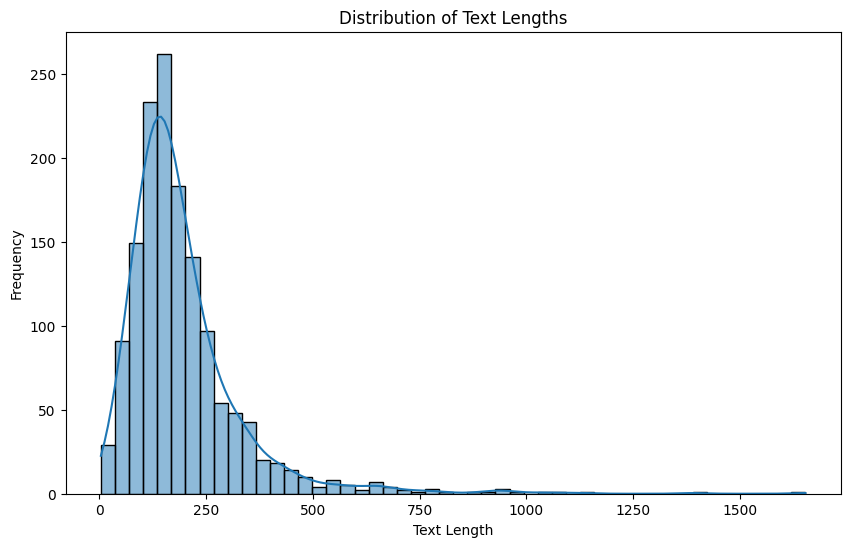

In [21]:
data['text_length'] = data['final_text'].apply(len)

print("Text Length Descriptive Statistics:")
display(data['text_length'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

### Word frequency visualization

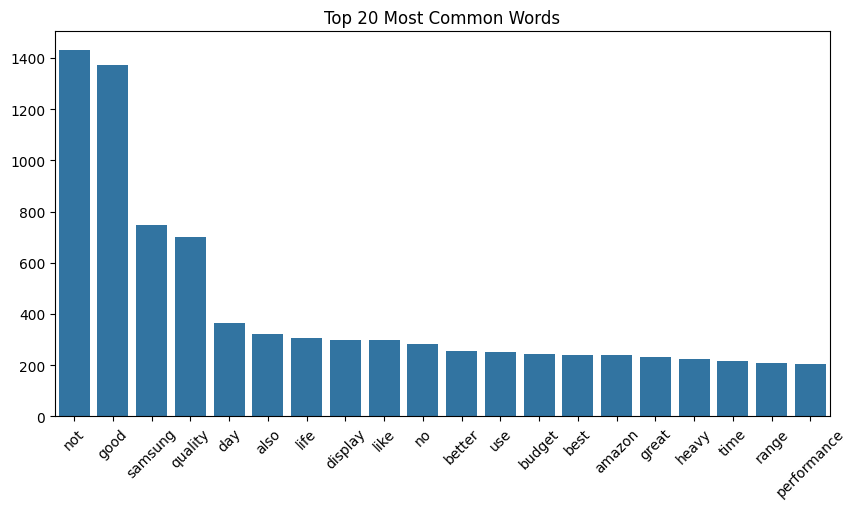

In [22]:
from collections import Counter
all_words = [word for tokens in data['lemmatized'] for word in tokens]
freq_dist = Counter(all_words)
common_words = freq_dist.most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(words), y=list(counts))
plt.title("Top 20 Most Common Words")
plt.xticks(rotation=45)
plt.show()


In [23]:
text = " ".join(data["final_text"])


### Final cleaned dataset

In [24]:
data.drop(['language', 'text', 'tokens', 'lemmatized', 'text_length'], axis=1, inplace=True)
display(data.head())
data.shape

,rating,clean_text,final_text
0,1,horrible product very disappointed with the ov...,horrible disappointed overall performance samsung
1,3,camera quality is not like megapixel camera qu...,quality not like megapixel quality low
2,4,overall got the mobile on the launch datebatte...,overall launch datebattery must appreciatedcam...
3,1,a big no from me it doesnt work with ghz wifi ...,big no doesnt work ghz wifi frequency ghz old ...
4,1,put your money somewhere else not worth buying...,put money somewhere else not worth buyingfault...


(1440, 3)

###  Generate wordcloud

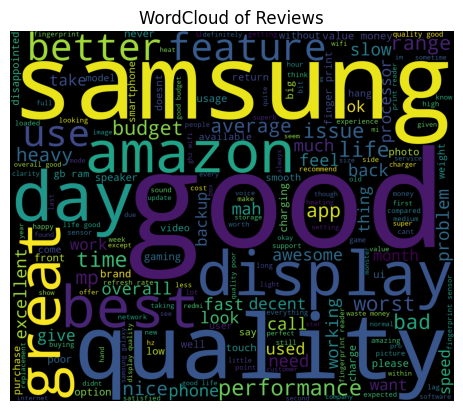

In [25]:
from wordcloud import WordCloud
wordcloud_stw = WordCloud(
                background_color= 'black',
                width = 1800,
                height = 1500,
                ).generate(text)
plt.axis('off')
plt.title("WordCloud of Reviews")
plt.imshow(wordcloud_stw)

### Sentiment Labels

In [26]:
def get_sentiment_afinn(text):
    score = text
    if score > 3:
        return "Positive"
    elif score < 3:
        return "Negative"
    else:
        return "Neutral"

In [27]:
data['Sentiment'] = data['rating'].apply(get_sentiment_afinn)
print(data[['rating', 'Sentiment']].head(10))

   rating Sentiment
0       1  Negative
1       3   Neutral
2       4  Positive
3       1  Negative
4       1  Negative
5       1  Negative
6       1  Negative
7       1  Negative
8       1  Negative
9       1  Negative


In [28]:
# Separate out the neutral rows using the rating_sentiment column
neutral_data = data[data['Sentiment'] == 'Neutral']
non_neutral_data = data[data['Sentiment'] != 'Neutral']

print("Neutral reviews shape:", neutral_data.shape)
print("Non-neutral reviews shape:", non_neutral_data.shape)

# Preview data
print("Neutral reviews (first 3 rows):")
display(neutral_data.head(3))
print("Non-neutral reviews (first 3 rows):")
display(non_neutral_data.head(3))


Neutral reviews shape: (199, 4)
Non-neutral reviews shape: (1241, 4)
Neutral reviews (first 3 rows):


,rating,clean_text,final_text,Sentiment
1,3,camera quality is not like megapixel camera qu...,quality not like megapixel quality low,Neutral
23,3,not so impressiveokay okaylittle over price th...,not impressiveokay okaylittle medium could not...,Neutral
30,3,good battery but average performance pros the ...,good average performance pro biggest advantage...,Neutral


Non-neutral reviews (first 3 rows):


,rating,clean_text,final_text,Sentiment
0,1,horrible product very disappointed with the ov...,horrible disappointed overall performance samsung,Negative
2,4,overall got the mobile on the launch datebatte...,overall launch datebattery must appreciatedcam...,Positive
3,1,a big no from me it doesnt work with ghz wifi ...,big no doesnt work ghz wifi frequency ghz old ...,Negative


### Initialize tf-idf vectorizer



In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=7000)

### Transform the Text Data



In [30]:
# Fit the vectorizer on all text data first
tfidf_vectorizer.fit(data['final_text'])
print("TF-IDF vectorizer fitted successfully.")

# Transform both neutral and non-neutral data using the same fitted vectorizer
tfidf_matrix_neutral = tfidf_vectorizer.transform(neutral_data['final_text'])
tfidf_matrix_non_neutral = tfidf_vectorizer.transform(non_neutral_data['final_text'])

print("Neutral text data transformed. Shape:", tfidf_matrix_neutral.shape)
print("Non-neutral text data transformed. Shape:", tfidf_matrix_non_neutral.shape)

TF-IDF vectorizer fitted successfully.
Neutral text data transformed. Shape: (199, 7000)
Non-neutral text data transformed. Shape: (1241, 7000)


### Convert TF-IDF Matrix to DataFrame



In [31]:
tfidf_df_neutral = pd.DataFrame(tfidf_matrix_neutral.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print("TF-IDF matrix (neutral) converted to DataFrame.")
print("Shape:", tfidf_df_neutral.shape)
display(tfidf_df_neutral.head())

tfidf_df_non_neutral = pd.DataFrame(tfidf_matrix_non_neutral.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print("TF-IDF matrix (non-neutral) converted to DataFrame.")
print("Shape:", tfidf_df_non_neutral.shape)
display(tfidf_df_non_neutral.head())

TF-IDF matrix (neutral) converted to DataFrame.
Shape: (199, 7000)


,aaya,aaya tha,ab,ab jab,abhi,abhi dinon,abide,abide indian,ability,ability imply,...,zoom capability,zoom detail,zoom image,zoom little,zoom mp,zoom overall,zoom photo,zoom picture,zoom pretty,zooming
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


TF-IDF matrix (non-neutral) converted to DataFrame.
Shape: (1241, 7000)


,aaya,aaya tha,ab,ab jab,abhi,abhi dinon,abide,abide indian,ability,ability imply,...,zoom capability,zoom detail,zoom image,zoom little,zoom mp,zoom overall,zoom photo,zoom picture,zoom pretty,zooming
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train Test split

In [32]:
from sklearn.model_selection import train_test_split

# Convert sparse matrices to arrays for easier handling
X_neutral_array = tfidf_matrix_neutral
X_non_neutral_array = tfidf_matrix_non_neutral

# NEUTRAL split
X_train_neutral, X_test_neutral, y_train_neutral, y_test_neutral = train_test_split(
    X_neutral_array, 
    neutral_data['Sentiment'].values,  # Convert to numpy array
    test_size=0.2, 
    random_state=42
)

print("Neutral Train shape:", X_train_neutral.shape)
print("Neutral Test shape:", X_test_neutral.shape)
print("Neutral y_train distribution:\n", pd.Series(y_train_neutral).value_counts())
print("Neutral y_test distribution:\n", pd.Series(y_test_neutral).value_counts())

# NON-NEUTRAL split
X_train_non_neutral, X_test_non_neutral, y_train_non_neutral, y_test_non_neutral = train_test_split(
    X_non_neutral_array,
    non_neutral_data['Sentiment'].values,  # Convert to numpy array
    test_size=0.2, 
    random_state=42
)

print("\nNon-neutral Train shape:", X_train_non_neutral.shape)
print("Non-neutral Test shape:", X_test_non_neutral.shape)
print("Non-neutral y_train distribution:\n", pd.Series(y_train_non_neutral).value_counts())
print("Non-neutral y_test distribution:\n", pd.Series(y_test_non_neutral).value_counts())

Neutral Train shape: (159, 7000)
Neutral Test shape: (40, 7000)
Neutral y_train distribution:
 Neutral    159
Name: count, dtype: int64
Neutral y_test distribution:
 Neutral    40
Name: count, dtype: int64

Non-neutral Train shape: (992, 7000)
Non-neutral Test shape: (249, 7000)
Non-neutral y_train distribution:
 Positive    579
Negative    413
Name: count, dtype: int64
Non-neutral y_test distribution:
 Positive    150
Negative     99
Name: count, dtype: int64


### Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def ConfusionMatrix(y_test, y_pred, model):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Greens')
    plt.title("Confusion Matrix - Sentiment Analysis")
    plt.show()


### Grid Search(Fine Tuning)

In [34]:
from sklearn.model_selection import GridSearchCV

def train_and_tune_model(estimator, param_grid, X_train, X_test, y_train, y_test, cv=5, scoring='accuracy'):
    grid = GridSearchCV(estimator, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    grid.fit(X_train, y_train)
    print("Best params:", grid.best_params_)
    print("Best cross-val score:", grid.best_score_)
    print("Test score:", grid.score(X_test, y_test))
    return grid


### Linear SVM

Linear SVM Accuracy: 0.9357429718875502

Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.95      0.92        99
    Positive       0.97      0.93      0.95       150

    accuracy                           0.94       249
   macro avg       0.93      0.94      0.93       249
weighted avg       0.94      0.94      0.94       249



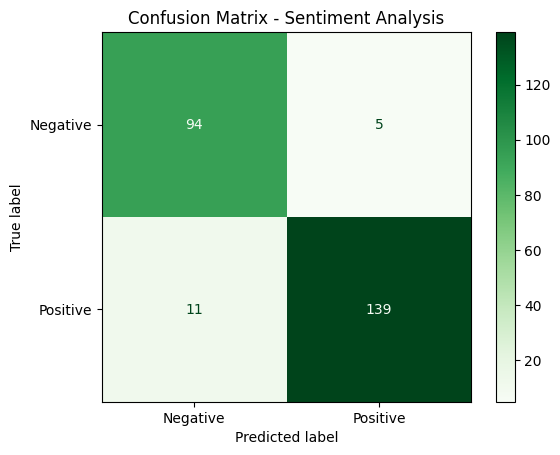

None


In [36]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_non_neutral, y_train_non_neutral)
y_pred_svm = svm_model.predict(X_test_non_neutral)

print("Linear SVM Accuracy:", accuracy_score(y_test_non_neutral, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test_non_neutral, y_pred_svm))
print(ConfusionMatrix(y_test_non_neutral, y_pred_svm, svm_model))


In [38]:
import joblib

# After training your LinearSVC model and TF-IDF vectorizer:
joblib.dump(svm_model, 'linearSVC_model.joblib')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']